In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp

from scripts.orbits import evolve
from scripts.basic_functions import output_dir, conv_factor_Msolar_eV

from classes.ns import NeutronStar
from classes.axionstar import AxionStar
from classes.minicluster import AxionMiniclusterNFW
from classes.particles import Particles

plt.rcParams['figure.figsize'] = [24, 16]

In [2]:
%%time

if __name__ == '__main__':
    mp.freeze_support()
    ncores = mp.cpu_count() - 1
    pool = mp.Pool(ncores)

    M_NS, R_NS = 1, 10
    NS = NeutronStar(M_NS, R_NS)

    vy_in = -200.
    M_AS = 1
    AS = AxionStar(M_AS, Particles.axionmass)
    b = AS.radius99()
    AS.center, AS.vcenter = [b, 1e16, 0], [0, vy_in, 0]
    
    M_MC = 1
    MC = AxionMiniclusterNFW(M_MC, Particles.axionmass, vdisp_type='Maxwell-Boltzmann')
    b = 0.2*MC.radius_trunc()
    MC.center, MC.vcenter = [b, 1e16, 0], [0, vy_in, 0]

    chosen_clump = MC
    length, nparticles, batch_size, conservation_check = np.array([-1,1])/300, int(1.e5), int(1.e2), False
    event, conservation_checks, mass_in, total_drawn = evolve(NS, chosen_clump, pool, nparticles, length = length, batch_size=batch_size, conservation_check = conservation_check)

CPU times: user 1min 41s, sys: 5.46 s, total: 1min 46s
Wall time: 2h 25min


In [3]:
Ntotal_drawn = total_drawn/mass_in*chosen_clump.mass
if chosen_clump == MC:
    Ntotal = 1e-5*conv_factor_Msolar_eV*chosen_clump.mass/Particles.axionmass
elif chosen_clump == AS:
    Ntotal = 1e-7*conv_factor_Msolar_eV*chosen_clump.mass/Particles.axionmass

axions_per_traj = Ntotal/Ntotal_drawn

In [4]:
part_trajs = np.load(output_dir + event + '/' + event + '.npy')
nparticles = int(part_trajs[-1][0]) + 1

readme = open(output_dir + event + '/README.txt', 'a')
readme.write('Number of saved trajectories: ' + str(nparticles) + '\n')
if conservation_check:
    readme.write('Energy and angular momentum conservation was checked. It is valid up to ' + str(np.round(np.max(conservation_checks), 2)) + ' percent.\n')
else:
    readme.write('Energy and angular momentum conservation was not checked.\n')
readme.write('Each trajectory correponds to ' + '{:.2e}'.format(axions_per_traj) + ' axions.\n')
readme.write('Axions were drawn from a cylinder of length ' + '{:.2e}'.format((length[1] - length[0])*chosen_clump.radius_trunc()) + ' km centered at ' + '{:.2e}'.format((length[1] + length[0])*chosen_clump.radius_trunc()) + ' km from the projection of the clump\'s center on the y-axis.')
readme.close()

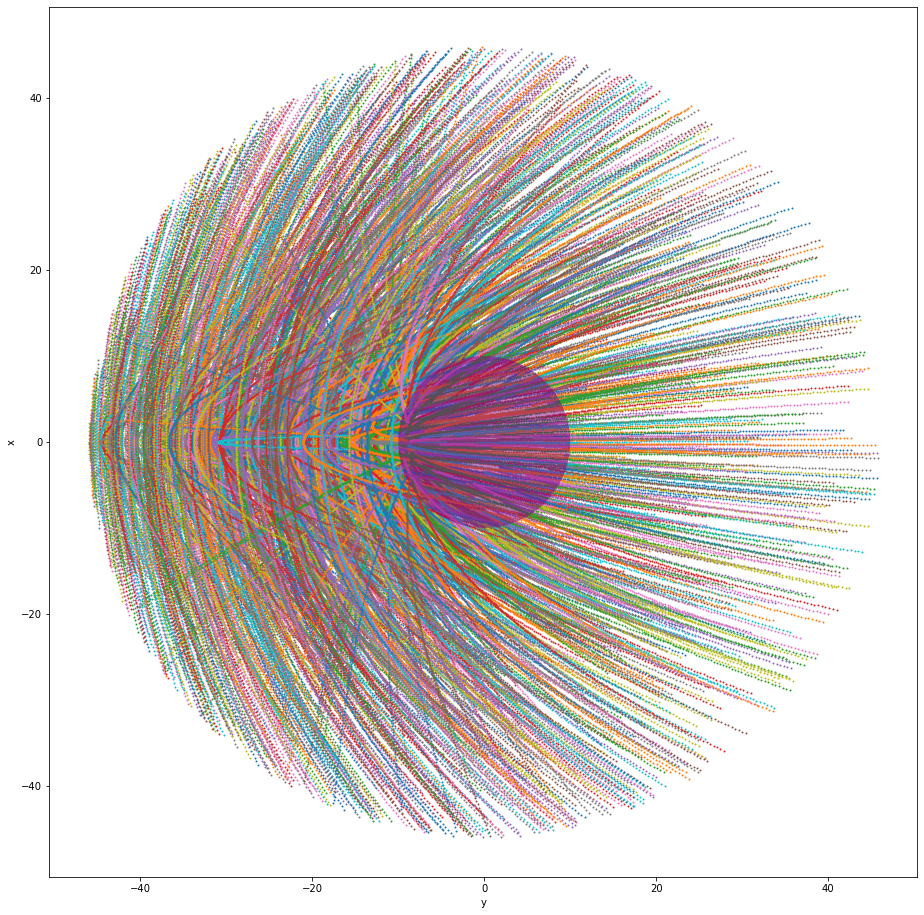

In [5]:
ax = plt.gca()
ax.set_aspect('equal')
nsamples = np.min([int(1e3), nparticles])
part_trajs_cut = part_trajs[:int(nsamples*float(len(part_trajs))/nparticles)]
for i in np.arange(int(part_trajs_cut[-1][0])):
    traj_chosen = np.array([[part_traj[3], part_traj[2]] for part_traj in part_trajs_cut if part_traj[0] == i]).T
    ax.scatter(traj_chosen[0], traj_chosen[1], s = 1)

NS = NeutronStar(M_NS, R_NS)
circle1 = plt.Circle((0, 0), NS.radius, facecolor='purple', alpha = 0.5)
ax.add_patch(circle1)
ax.set_aspect('equal')

plt.xlabel('y')
plt.ylabel('x')
plt.savefig(output_dir + event + '/' + event + '.png')